# Wealth transfer

In [ ]:
!pip install agentpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.0 MB/s eta 0:00:00


This notebook presents a tutorial for beginners on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package.
It demonstrates how to create a basic model with a custom agent type, run a simulation, record data, and visualize results.

In [ ]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns

## About the model

The model explores the distribution of wealth under a trading population of agents.
Each agent starts with one unit of wealth.
During each time-step, each agents with positive wealth
randomly selects a trading partner and gives them one unit of their wealth.
We will see that this random interaction will create an inequality of wealth that
follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).
The original version of this model been written in [MESA](https://mesa.readthedocs.io/)
and can be found [here](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html).

## Model definition

We start by defining a new type of `Agent` with the following methods:

- `setup()` is called automatically when a new agent is created and initializes a variable `wealth`.
- `wealth_transfer()` describes the agent's behavior at every time-step and will be called by the model.

In [ ]:
class WealthAgent1(ap.Agent):

    """ An agent with wealth - Rodolfo """

    def setup(self):
        self.wealth = np.random.randint(1, 51)
        self.utility = self.wealth

    def wealth_transfer(self):

        if self.wealth > 1:
            partner = self.model.agents1.random()
            transfer_amount = 1
            self.wealth -= transfer_amount
            partner.wealth += transfer_amount

class WealthAgent2(ap.Agent):

    """ An agent with wealth "- Sofia"""

    def setup(self):

        self.wealth = 1
        self.utility = 1

    def wealth_transfer(self):
      partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
      if partner.wealth < self.wealth:
            amount = min(2, self.wealth)
            self.wealth -= amount
            partner.wealth += amount
            self.utility += amount

class WealthAgent3(ap.Agent):

    """ An agent with wealth  - Mariana"""

    def setup(self):

        self.wealth = 1
        self.utility = 1

    def wealth_transfer(self):
        partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
        otherw = list(partner.wealth)[0]
        if partner.wealth > self.wealth:
          if self.wealth < 15:
            self.wealth += (otherw - 1)
            partner.wealth = 1
            self.utility += (otherw - 1)

class WealthAgent4(ap.Agent):

    """ An agent with wealth - Roger"""

    def setup(self):

        self.wealth = np.random.randint(1, 101)
        self.utility = 1

    def wealth_transfer(self):

        if self.wealth > 0:

            partner = (self.model.agents1 + self.model.agents2 + self.model.agents4).random()
            if partner.wealth <= self.wealth:
                partner.wealth += 1
                self.wealth -= 1

Next, we define a method to calculate the [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient),
which will measure the inequality among our agents.

In [ ]:
def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799

    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad

Finally, we define our [`Model`](https://agentpy.readthedocs.io/en/stable/reference_models.html) with the following methods:

- `setup` defines how many agents should be created at the beginning of the simulation.
- `step` calls all agents during each time-step to perform their `wealth_transfer` method.
- `update` calculates and record the current Gini coefficient after each time-step.
- `end`, which is called at the end of the simulation, we record the wealth of each agent.

In [ ]:
class WealthModel(ap.Model):

    """ A simple model of random wealth transfers """

    def setup(self):

        self.agents1 = ap.AgentList(self, self.p.agents, WealthAgent1)
        self.agents2 = ap.AgentList(self, self.p.agents, WealthAgent2)
        self.agents3 = ap.AgentList(self, self.p.agents, WealthAgent3)
        self.agents4 = ap.AgentList(self, self.p.agents, WealthAgent4)

    def step(self):

        self.agents1.wealth_transfer()
        self.agents2.wealth_transfer()
        self.agents3.wealth_transfer()
        self.agents4.wealth_transfer()

    def update(self):

        self.record('Gini Coefficient (Agent 1)', gini(self.agents1.wealth))
        self.record('Gini Coefficient (Agent 2)', gini(self.agents2.wealth))
        self.record('Gini Coefficient (Agent 3)', gini(self.agents3.wealth))
        self.record('Gini Coefficient (Agent 4)', gini(self.agents4.wealth))

        self.record('Utility (Agent 1)', list(self.agents1.utility))
        self.record('Utility (Agent 2)', list(self.agents2.utility))
        self.record('Utility (Agent 3)', list(self.agents3.utility))
        self.record('Utility (Agent 4)', list(self.agents4.utility))

    def end(self):

        self.agents1.record('wealth')
        self.agents2.record('wealth')
        self.agents3.record('wealth')
        self.agents4.record('wealth')

        self.record("Task predicate 1", all(list(self.agents1.wealth)))
        self.record("Task predicate 2", all(list(self.agents2.wealth)))
        self.record("Task predicate 3", all(list(self.agents3.wealth)))
        self.record("Task predicate 4", all(list(self.agents4.wealth)))

## Simulation run

To prepare, we define parameter dictionary with a [random seed](https://agentpy.readthedocs.io/en/stable/guide_random.html), the number of agents, and the number of time-steps.

In [ ]:
parameters = {
    'agents': 50,
    'steps': 100,
    'seed': 42,
}

To perform a simulation, we initialize our model with a given set of parameters and call [`Model.run()`](https://agentpy.readthedocs.io/en/stable/reference_models.html).

In [ ]:
model = WealthModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.509733
Simulation finished


## Output analysis

The simulation returns a [`DataDict`](https://agentpy.readthedocs.io/en/stable/reference_output.html) with our recorded variables.

In [ ]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 3 keys
'variables': 
    'WealthModel': DataFrame with 12 variables and 101 rows
    'WealthAgent1': DataFrame with 1 variable and 50 rows
    'WealthAgent2': DataFrame with 1 variable and 50 rows
    'WealthAgent3': DataFrame with 1 variable and 50 rows
    'WealthAgent4': DataFrame with 1 variable and 50 rows
'reporters': DataFrame with 1 variable and 1 row
}

The output's `info` provides general information about the simulation.

In [ ]:
results.info

{'model_type': 'WealthModel',
 'time_stamp': '2025-01-10 04:53:30',
 'agentpy_version': '0.1.5',
 'python_version': '3.10.',
 'experiment': False,
 'completed': True,
 'created_objects': 200,
 'completed_steps': 100,
 'run_time': '0:00:00.509733'}

To explore the evolution of inequality,
we look at the recorded [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the model's variables.

In [ ]:
results.variables.WealthModel.head()

,Gini Coefficient (Agent 1),Gini Coefficient (Agent 2),Gini Coefficient (Agent 3),Gini Coefficient (Agent 4),Utility (Agent 1),Utility (Agent 2),Utility (Agent 3),Utility (Agent 4),Task predicate 1,Task predicate 2,Task predicate 3,Task predicate 4
t,,,,,,,,,,,,
0,0.286630,0.000000,0.000000,0.303229,"[15, 26, 3, 3, 37, 33, 17, 6, 50, 19, 31, 39, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
1,0.441138,0.549778,0.568342,0.573400,"[15, 26, 3, 3, 37, 33, 17, 6, 50, 19, 31, 39, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[42, 75, 33, 48, 0, 26, 0, 30, 77, 1, 36, 66, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
2,0.507292,0.700000,0.402796,0.651438,"[15, 26, 3, 3, 37, 33, 17, 6, 50, 19, 31, 39, ...","[3, 3, 2, 3, 4, 2, 4, 3, 4, 4, 2, 4, 3, 4, 3, ...","[42, 75, 33, 48, 24, 26, 45, 30, 77, 35, 36, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
3,0.532889,0.775789,0.370629,0.648243,"[15, 26, 3, 3, 37, 33, 17, 6, 50, 19, 31, 39, ...","[3, 3, 3, 4, 5, 2, 4, 3, 6, 4, 3, 4, 3, 5, 4, ...","[42, 75, 33, 48, 24, 26, 45, 30, 77, 35, 36, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None
4,0.549420,0.696364,0.356478,0.657966,"[15, 26, 3, 3, 37, 33, 17, 6, 50, 19, 31, 39, ...","[4, 3, 3, 4, 5, 2, 5, 3, 7, 4, 3, 5, 4, 7, 4, ...","[42, 75, 33, 48, 24, 26, 45, 30, 77, 35, 36, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",None,None,None,None


In [ ]:
TP = results.variables.WealthModel["Task predicate 1"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 1


In [ ]:
TP = results.variables.WealthModel["Task predicate 2"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 0


In [ ]:
TP = results.variables.WealthModel["Task predicate 3"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 1


In [ ]:
TP = results.variables.WealthModel["Task predicate 4"].tail(1).values[0]
print(f"Psi(r) = {int(TP)}")

Psi(r) = 0


To visualize this data,
we can use [`DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).

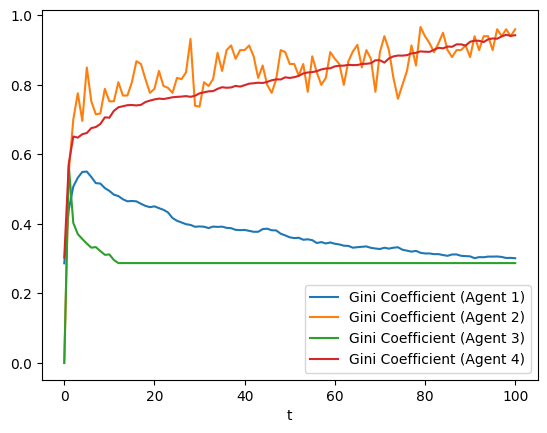

In [ ]:
data = results.variables.WealthModel
ax = data.plot()

To look at the distribution at the end of the simulation,
we visualize the recorded agent variables with [seaborn](https://seaborn.pydata.org/).

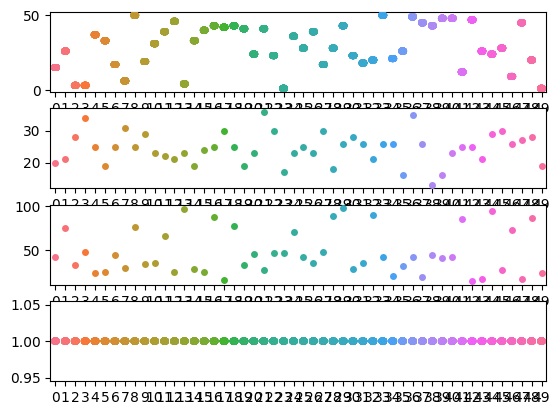

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axs = plt.subplots(nrows=4)
df = pd.DataFrame(list(data["Utility (Agent 1)"]))
sns.stripplot(data=df, ax=axs[0]);
df = pd.DataFrame([list(data["Utility (Agent 2)"])[99]])
sns.stripplot(data=df, ax=axs[1]);
df = pd.DataFrame([list(data["Utility (Agent 3)"])[99]])
sns.stripplot(data=df, ax=axs[2])
df = pd.DataFrame(list(data["Utility (Agent 4)"]))
sns.stripplot(data=df, ax=axs[3]);

**¿Cuál es el ambiente?**
Todos los agentes creados y su wealth.

**¿Qué sería lo análogo a la función de percepción "see()"?**
Es equivalente a la parte donde puede visualizar a todos los agentes.

**¿Cuáles son los perceptos?**
En la mayoría de los casos, observa un agente y elige uno al azar.

**¿Qué sería lo análogo a la función de decisión de acciones "next()"?**
Lo análogo a la función next es la parte donde evalua funciones booleanas de acuerdo al estado interno del agente y la del que fue escogido.

**¿Cuáles son los estados internos del agente?**
Utility y Wealth.

**¿Qué sería lo análogo a la función de acción "action()"?**
Esto sería donde se lleva a cabo la acción de intercambio de dinero entre agentes.

**¿Cuáles son las acciones posibles?**
Quitar dinero, dar dinero y no hacer nada.